In [1]:
#Packages

import warnings
warnings.filterwarnings('ignore')

import glob
import csv

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from itertools import cycle, islice

from PIL import Image

from pymks import (plot_microstructures, PrimitiveTransformer, TwoPointCorrelation)

plots_path = "./../../figures/statistics/"


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [12]:
#Append all images to one list.
images = []
path = "./../../data/binarized/evolution/"
for filename in glob.glob(path + "*.tif"):
    im=Image.open(filename)
    images.append(im)
np.shape(images[0])

(600, 600)

In [13]:
#List comprehension to convert the members of the "images" list to arrays.

imarrays = [np.array(x) for x in images]
imarrays[0].shape

(600, 600)

In [14]:
#Stacking all image arrays to create the 'sample' dimension and to convert the list to an array.

data_a = np.stack(imarrays, axis=0)
data_a.shape

(40, 600, 600)

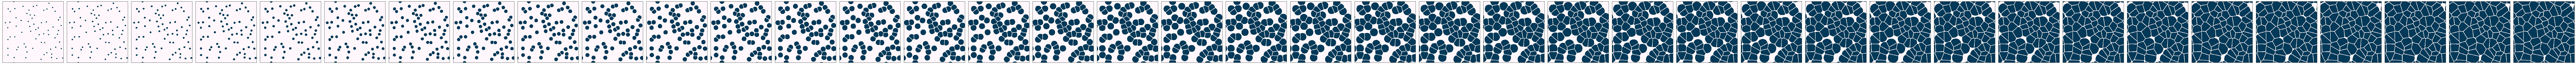

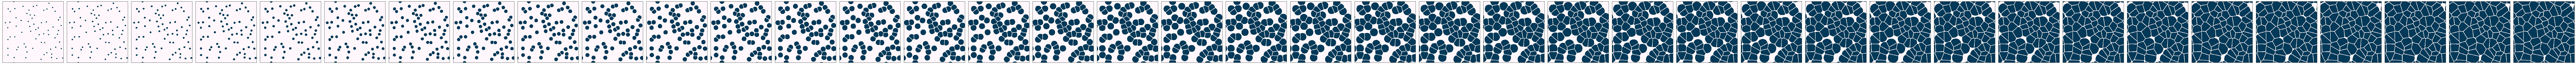

In [15]:
#Visualizing the evolution.

plot_microstructures(*data_a[0:41], cmap='PuBu', colorbar=False)

In [16]:
#List comprehension to add the "phases" axis with the PrimitiveTransformer class.

data = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(data_a)
data.shape

(40, 600, 600, 2)

In [17]:
#Calculating two-point statistics.

two_points = TwoPointCorrelation(periodic_boundary=True, cutoff=130, 
                                 correlations=[(1,1), (0, 1)]).transform(data)

initial_shape = two_points.shape
initial_shape

(40, 261, 261, 2)

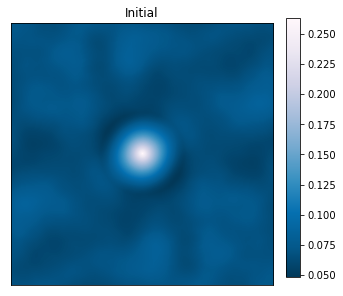

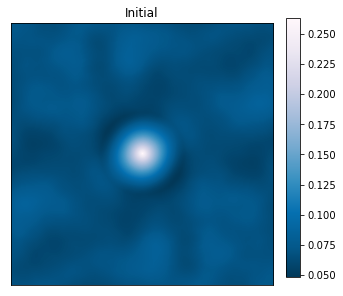

In [18]:
#Visualizing two-point statistics.

plot_microstructures(two_points[10, :, :, 0], titles=['Initial'], 
                     cmap='PuBu_r', showticks=False)

In [19]:
#Printing recrystallized volume fractions.

print('Recrystallized Volume Fraction 10 = ', two_points[10, 130, 130, 0].compute())
print('Recrystallized Volume Fraction 25 = ', two_points[25, 130, 130, 0].compute())
print('Recrystallized Volume Fraction 39 = ', two_points[39, 130, 130, 0].compute())

Recrystallized Volume Fraction 10 =  0.26285
Recrystallized Volume Fraction 25 =  0.7360944444444445
Recrystallized Volume Fraction 39 =  0.864188888888889


In [20]:
#Creating a list with the recrystallized fractions.

rex_fraction_list=[]
for i in range(40):
    rex_fraction_list.insert(i, two_points[i, 130, 130, 0].compute())

In [21]:
df_rex=pd.DataFrame(rex_fraction_list)
df_rex.rename(columns={df_rex.columns[0]: "Two-Point Statistics" }, inplace = True)

In [22]:
#Normalizing the data to account for grain boundaries.

normalized_rex = (rex_fraction_list-min(rex_fraction_list))/(max(rex_fraction_list)-min(rex_fraction_list))
df_rex['Normalized'] = (normalized_rex)

path_b = "./../../data/extra/"
micress = pd.read_csv(path_b + "phase-field-fraction.csv")

micress['Phase-Field']=micress['Phase-Field']*0.01
df_rex['Phase-Field']= micress['Phase-Field'].values

time_steps = pd.Series(np.arange(0,40))
df_rex.insert(loc=0, column='Time Steps', value=time_steps)

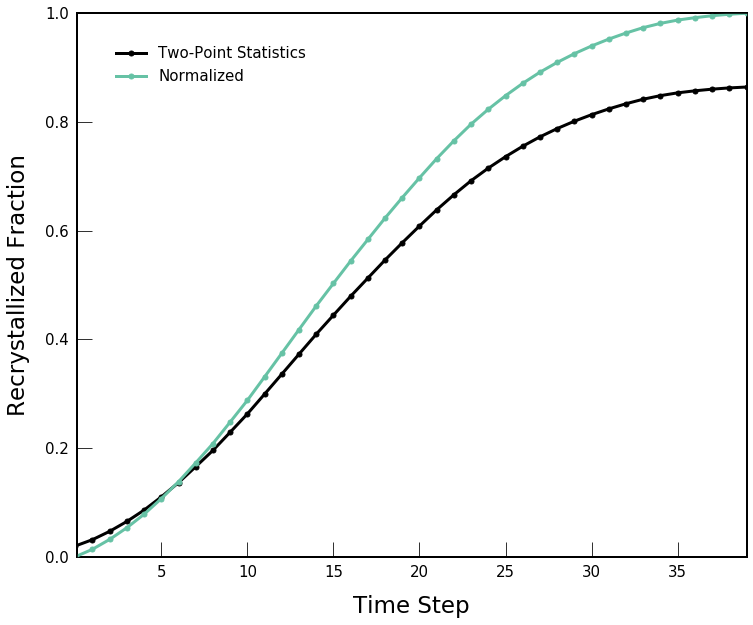

In [24]:
#Plotting rex fraction evolution (two points vs. normalized).

plt.rcParams.update({'font.size': 15})

my_colors = list(islice(cycle(['black', '#66c2a5']), None, len(df_rex)))
rex_fig = df_rex.plot(x ='Time Steps', y=['Two-Point Statistics', 'Normalized'],
                      figsize=(12, 10), color=my_colors, linewidth=3, marker='o', markersize=5)

plt.tick_params(axis="both", size=15, direction="in", pad=8)
plt.legend(frameon=False, bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0)

rex_fig.patch.set_edgecolor('black')
rex_fig.patch.set_linewidth('2')

rex_fig.set_xlabel("Time Step", fontsize=23, labelpad=15)
rex_fig.set_ylabel("Recrystallized Fraction", fontsize=23, labelpad=15)

plt.xlim([0.1, 39])
plt.ylim([0, 1])

#plt.savefig(plots_path + 'rex_fraction.png', facecolor='w', dpi=600)

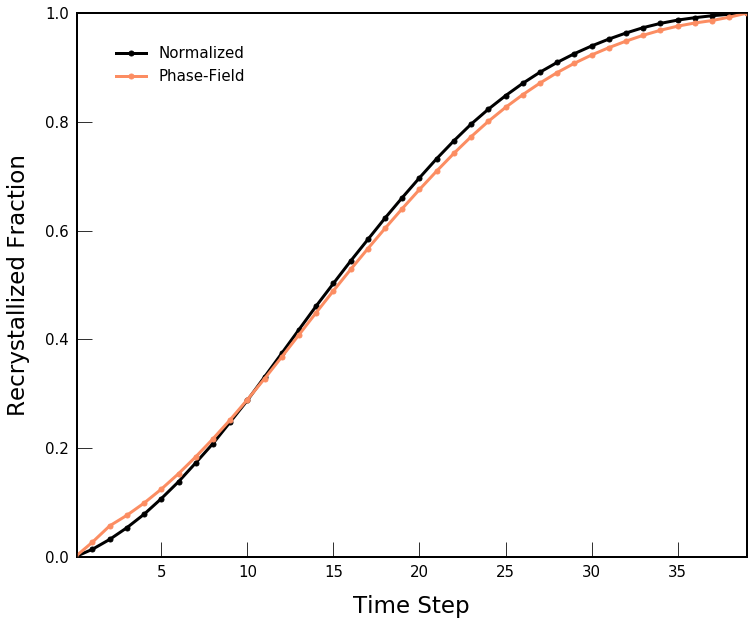

In [25]:
#Plotting rex fraction evolution (normalized vs. phase-field).

plt.rcParams.update({'font.size': 15})

my_colors = list(islice(cycle(['black', '#fc8d62']), None, len(df_rex)))
rex_fig = df_rex.plot(x ='Time Steps', y=['Normalized', 'Phase-Field'],
                      figsize=(12, 10), color=my_colors, linewidth=3, marker='o', markersize=5)

plt.tick_params(axis="both", size=15, direction="in", pad=8)
plt.legend(frameon=False, bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0)

rex_fig.patch.set_edgecolor('black')
rex_fig.patch.set_linewidth('2')

rex_fig.set_xlabel("Time Step", fontsize=23, labelpad=15)
rex_fig.set_ylabel("Recrystallized Fraction", fontsize=23, labelpad=15)

plt.xlim([0.1, 39])
plt.ylim([0, 1])

#plt.savefig(plots_path + 'normalized_rex_fraction.png', facecolor='w', dpi=600)

In [26]:
#Reshaping two-point statistics for the PCA model.

reshaped_two_points=two_points.reshape(40, -1)
reshaped_two_points.shape

(40, 136242)

In [27]:
#PCA

pca = PCA(svd_solver='full', n_components=3)

pc_scores=pca.fit_transform(reshaped_two_points)
pc_scores.shape

(40, 3)

In [31]:
#First principal component (PC1).

pc1, pc2, pc3 = np.split(pc_scores, 3, axis=1)

print(pc1.shape)
#print(pc1)

(40, 1)


In [32]:
zeros=np.zeros((40, 2))
reshaped_pc1=np.hstack((pc1,zeros))

#print(reshaped_pc1)
#print(reshaped_pc1.shape)
#print(reshaped_pc1[26])

In [33]:
#Explained variance by each principal component.

exp_var_pca=pca.explained_variance_ratio_*100
cum_sum=np.cumsum(pca.explained_variance_ratio_)*100
cum_sum_2d = [ '%.2f' % elem for elem in cum_sum ]
cum_sum_2d = np.array(cum_sum_2d)

print(exp_var_pca)

[9.51393010e+01 4.84004162e+00 1.42475977e-02]


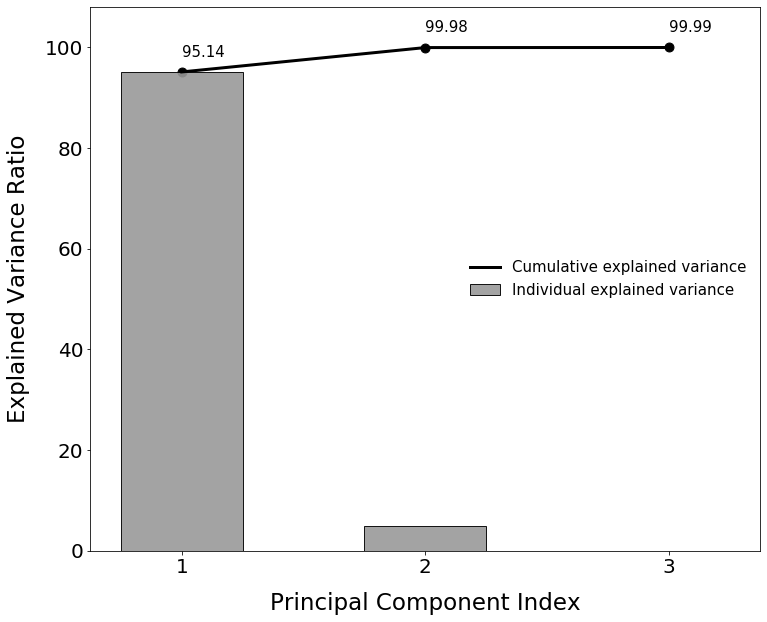

In [34]:
#plot explained variance

fig = plt.figure(1, figsize=(12, 10))

x1 = range(1, len(exp_var_pca)+1)
y1 = exp_var_pca
x2 = range(1, len(cum_sum)+1)
y2 = cum_sum

plt.bar(x1, y1, color='#999999', edgecolor='black', linewidth='1', alpha=0.9, width = 0.5, align='center', label='Individual explained variance')

plt.plot(x2, y2, label='Cumulative explained variance', c='black', linewidth=3)
plt.scatter(x2, y2, s=80, facecolors='black', edgecolors='black')

for i, txt in enumerate(cum_sum_2d):
    plt.annotate(txt, (x2[i], y2[i]), size=15, xytext=(x2[i], y2[i]+3))
    
plt.xlabel('Principal Component Index', fontsize=23, labelpad=15)
plt.ylabel('Explained Variance Ratio', fontsize=23, labelpad=15)

plt.xticks(np.arange(1, 4, step=1), fontsize=20)
plt.yticks(fontsize=20)

plt.legend(frameon=False, loc='best')
plt.ylim([0, 108])

plt.show()

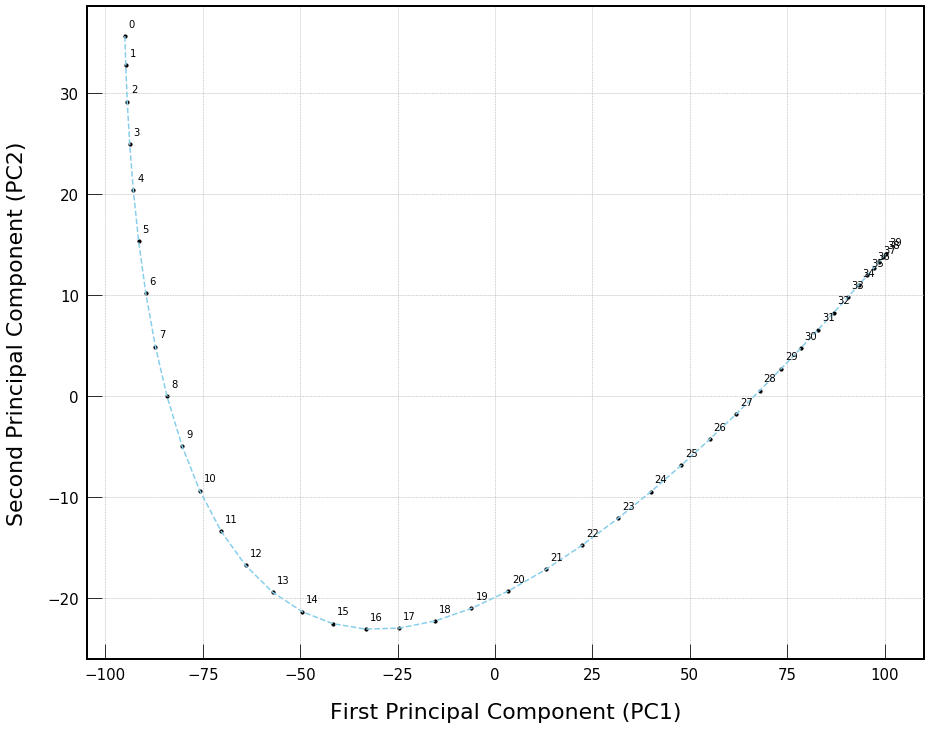

In [35]:
#Visualizing principal components.

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)

plt.scatter(pc_scores[:,0], pc_scores[:,1], c='black', marker='o', s=10)
plt.plot(pc_scores[:,0], pc_scores[:,1], c='skyblue', ls='--')

ax.set_xlabel("First Principal Component (PC1)",  fontsize=22, labelpad=20)
ax.set_ylabel("Second Principal Component (PC2)",  fontsize=22, labelpad=20)

ax.tick_params(axis="both", size=15, direction="in", pad=8)

ax.grid(which='major', axis='both', linestyle = '--', linewidth = 0.5)

ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('2') 

n = range(0,40)
for i, txt in enumerate(n):
    plt.annotate(txt, (pc_scores[i,0], pc_scores[i,1]), xytext=(pc_scores[i,0]+1, pc_scores[i,1]+0.9), size=10)

#fig.savefig(plots_path + 'evolution_principal_components.png', facecolor='w', dpi=600)
fig.show()

In [37]:
#Inverting and reshaping the data.

two_points_inv_pc = pca.inverse_transform(pc_scores)
two_points_inv_pc1 = pca.inverse_transform(reshaped_pc1)

recovered_two_points_pc = np.reshape(two_points_inv_pc, initial_shape)
recovered_two_points_pc1 = np.reshape(two_points_inv_pc1, initial_shape)

print(two_points_inv_pc.shape)
print(recovered_two_points_pc.shape)
#print(recovered_two_points_pc)

(40, 136242)
(40, 261, 261, 2)


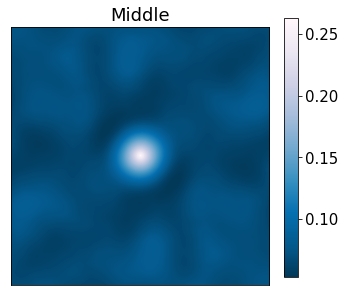

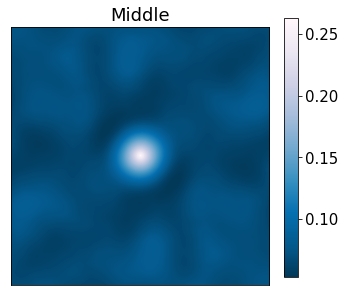

In [38]:
#Recovered two-point statistics using both PC scores. 
plot_microstructures(recovered_two_points_pc[10, :, :, 0], titles=['Middle'], cmap='PuBu_r', showticks=False)

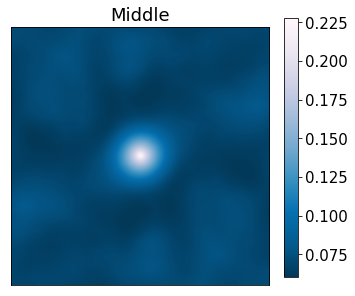

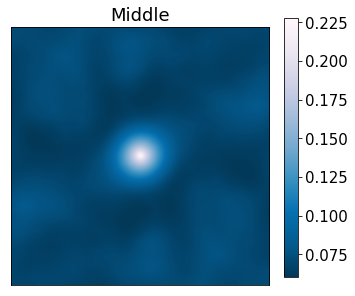

In [39]:
#Recovered first two-point statistics using only PC1.
plot_microstructures(recovered_two_points_pc1[10, :, :, 0], titles=['Middle'], cmap='PuBu_r', showticks=False)